In [1]:
import pandas as pd
import numpy as np


In [ ]:
names = """\
0) Target
1) Alcohol
2) Malic acid
3) Ash
4) Alcalinity of ash
5) Magnesium
6) Total phenols
7) Flavanoids
8) Nonflavanoid phenols
9) Proanthocyanins
10)Color intensity
11)Hue
12)OD280/OD315 of diluted wines
13)Proline"""

names = [x.split(")")[1].strip() for x in names.split("\n")]

df = pd.read_csv("./wine/wine.data", header=None)
df.columns = names

In [ ]:
from scipy.stats import cauchy as Cauchy
from functools import partial

class Prior_probability():

    def __init__(self, data, shuffle = True, loc = 24):
        self.data = np.array(data)
        self.variance = (11/3)**2
        if shuffle:
            np.random.shuffle(self.data)
        self.aprior_pdf = partial(Cauchy.pdf, loc = loc)


    def __call__(self, n):
        '''
        Возвращает распределение при вызове, n - число элементов выборки
        '''
        return partial(self.prior_pdf, n = n, scaling = self.scaling_constant(n))


    @staticmethod
    def monte_carlo_integration(func, a, b, num_samples):
        '''
        Интегрирует по Монте-Карло
        '''
        random_samples = np.random.uniform(a, b, num_samples)
        integral = (b - a) * np.mean(func(random_samples))
        return integral


    def p_t(self, t, n):
        '''
        P(X | \theta), если что здесь t - ndarray, они там бродкастятся и суммируются по строкам (вдоль выборки), а потом схлопываются в монте карло в monte_carlo_integration
        '''
        return np.exp(-0.5 * np.sum((self.data[:n] - t[:, None]) ** 2, axis = 1)/ self.variance)/ np.sqrt(2 * np.pi) ** n


    def scaling_constant(self, n):
        '''
        Считает константу
        '''
        n_data_mean = np.mean(self.data[:n])
        l_bound, r_bound = n_data_mean - 3 * np.sqrt(self.variance), n_data_mean + 3 * np.sqrt(self.variance)
        return self.monte_carlo_integration(partial(self.prior_pdf, n = n), l_bound, r_bound, 1000000)


    def prior_pdf(self, t, n, scaling = None):
        '''
        Апостериорное P(\theta | X)
        '''
        if scaling is not None:
            return self.aprior_pdf(t) * self.p_t(t, n)/ scaling
        return self.aprior_pdf(t) * self.p_t(t, n)

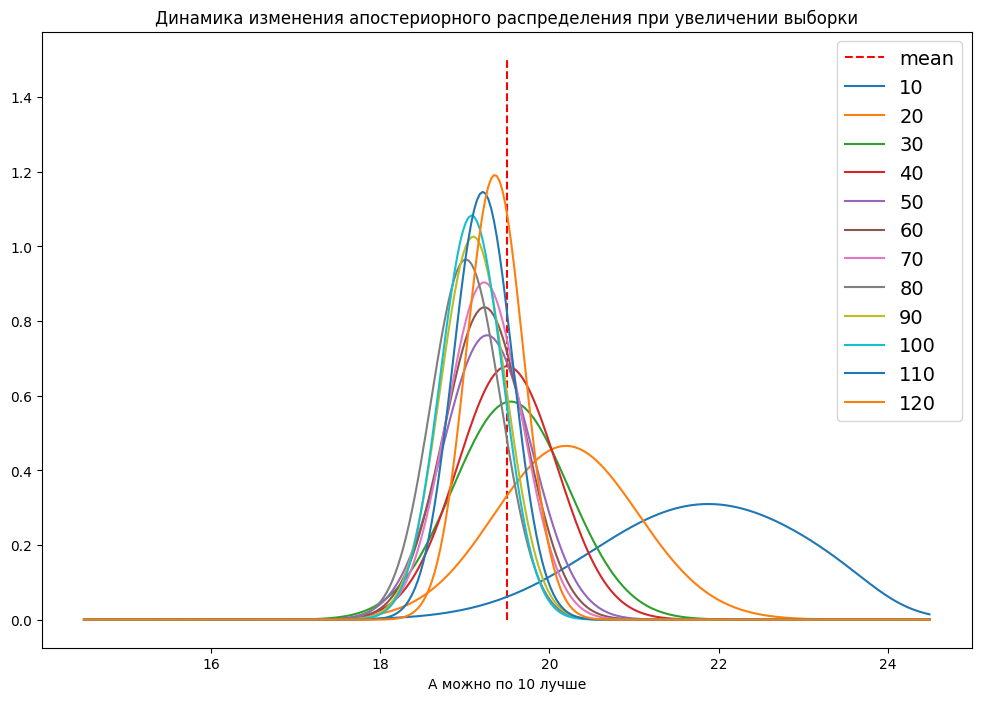

In [ ]:
import matplotlib.pyplot as plt
data = np.array(df['Alcalinity of ash'])
d_mean, d_std = np.mean(data), np.std(data)
prior = Prior_probability(data)

plt.figure(figsize=(12,8))

x = np.linspace(d_mean - 1.5 * d_std, d_mean + 1.5 * d_std, 300)
plt.plot(np.repeat([d_mean], [50]), np.linspace(0, 1.5, 50), '--r', label = "mean")
for n in range(10, 130, 10):
    n_prior_prob = prior(n)
    plt.plot(x, n_prior_prob(x), label = n)

plt.title("Динамика изменения апостериорного распределения при увеличении выборки")
plt.legend(fontsize=14)
plt.xlabel("А можно по 10 лучше")
plt.show()


$$\mathcal{L}(\theta) = \mathsf{E} \exp\left(-\frac{\xi^2\sqrt{\eta}}{1+\theta^2}\right),$$

In [ ]:
from scipy.stats import poisson
from scipy.stats import norm


def comp_2d_deriv_expect(func, dist1, dist2, sample_size = 10000):
    sample_1, sample_2 = dist1.rvs(size = sample_size), dist2.rvs(size = sample_size)
    sample_1_np, sample_2_np = np.array(sample_1), np.array(sample_2)
    return np.mean(func(sample_1_np, sample_2_np))


def derivative(eta, xi, theta = 0):
    return 2 * theta * np.exp(- xi**2 * np.sqrt(eta)/ (1 + theta**2))/(1 + theta**2)**2


def foo(eta, xi, theta = 0):
    return np.exp(- xi**2 * np.sqrt(eta)/ (1 + theta**2))

In [ ]:
standart_normal_dist = norm(loc = 0, scale = 1)
poisson_dist = poisson(mu = 5.)

theta_optim = np.random.sample() - 0.5
lr = 0.005
delta_conv = 1e-6
for i in range(1000000000):
    gradient = comp_2d_deriv_expect(partial(derivative, theta = theta_optim), poisson_dist, standart_normal_dist)
    theta_optim = theta_optim - lr * gradient
    if i % 300 == 0:
        print("step " + str(i) + ": grad = " + str(gradient) + ", theta = " + str(theta_optim))
    if abs(gradient) < delta_conv:
        print("step " + str(i) + ": grad = " + str(gradient) + ", THETA OPTIM = " + str(theta_optim))
        break

step 0: grad = 0.09588087724427045, theta = 0.10834427516646278
step 300: grad = 0.025774723083835323, theta = 0.029005907824681695
step 600: grad = 0.006911968201445211, theta = 0.007700274492248362
step 900: grad = 0.001820253669216647, theta = 0.0020419561252104537
step 1200: grad = 0.00047267155471923417, theta = 0.0005414499395191095
step 1500: grad = 0.00012711770106727115, theta = 0.00014355286277415637
step 1800: grad = 3.400317496079659e-05, theta = 3.804772109510909e-05
step 2100: grad = 8.931499129589554e-06, theta = 1.0078462686429893e-05
step 2400: grad = 2.3251214904735556e-06, theta = 2.6683209613396577e-06
step 2593: grad = 9.945062243621357e-07, THETA OPTIM = 1.134664851973627e-06


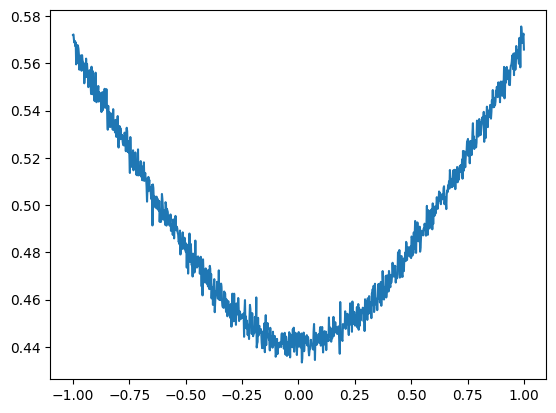

In [ ]:
X = np.linspace(-1, 1, 1000)
Y = np.empty(X.shape)
for idx,  theta in enumerate(X):
    Y[idx] = comp_2d_deriv_expect(partial(foo, theta = theta), poisson_dist, standart_normal_dist)
plt.plot(X, Y)
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('./flats_moscow.txt', sep='\t', index_col=0)
data.head()

,price,totsp,livesp,kitsp,dist,metrdist,walk,brick,floor,code
n,,,,,,,,,,
1,81,58,40,6.0,12.5,7,1,1,1,3
2,75,44,28,6.0,13.5,7,1,0,1,6
3,128,70,42,6.0,14.5,3,1,1,1,3
4,95,61,37,6.0,13.5,7,1,0,1,1
5,330,104,60,11.0,10.5,7,0,1,1,3


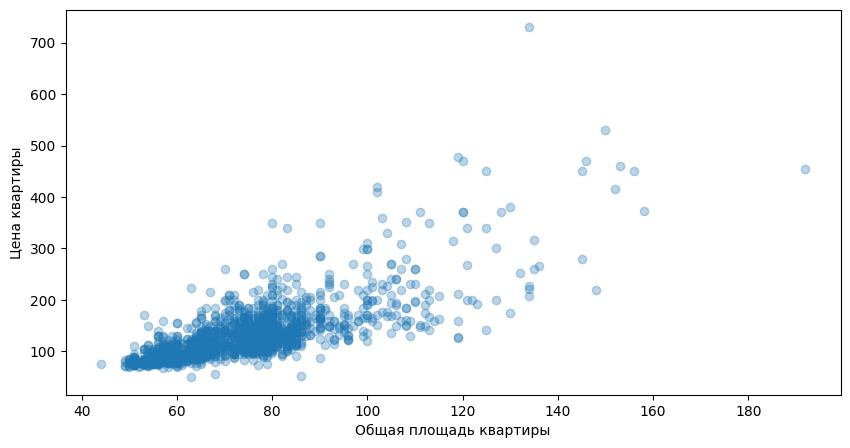

In [ ]:
plt.figure(figsize=(10, 5))
plt.scatter(data['totsp'], data['price'], alpha=0.3)
plt.xlabel('Общая площадь квартиры')
plt.ylabel('Цена квартиры');

$$Y = \theta_0 + \theta_1 X + \epsilon$$
$$\theta_0, \theta_1 \sim N(0, 20)$$
$$\epsilon \sim N(0, \sigma^2)$$
$$\sigma^2 \sim HalfCauchy$$

In [ ]:
X, Y = data['totsp'], data['price']

In [ ]:
import pymc as pm

with pm.Model() as model:
    sigma_prior = pm.HalfCauchy('sigma', beta=10, initval=1.)
    theta_0_prior = pm.Normal('theta_0', 0, sigma=20)
    theta_1_prior = pm.Normal('theta_1', 0, sigma=20)

    x = pm.MutableData('x', X, dims='dims')

    y_distr = pm.Normal(
        'y',
        mu=theta_0_prior + theta_1_prior * x,
        sigma=sigma_prior,
        observed=Y,
        dims='dims'
    )

    trace = pm.sample(3000, chains=2)


**Видно, что апостериорные распределения признаков и дисперсии шума очень сильно отклонились от априоных: например дисперсия $\theta_1$ сильно меньше изначально заданной var = 20 (у $\theta_0$ тоже меньше, но не настолько). Очевидно смещение центра распределения (от 0 до ~ -60 и от 0 до ~2.55). Также распределение шума из половины Коши стало более номально распределенным и также отклонилось от начального среднего.**

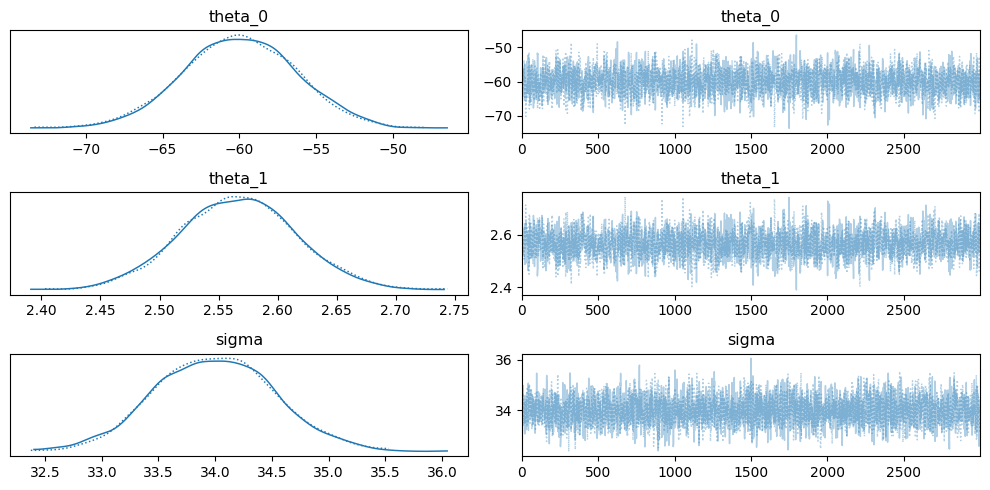

In [ ]:
pm.plot_trace(trace, figsize=(10, 5))
plt.tight_layout()

In [ ]:
import numpy as np
x_grid = np.linspace(np.min(X), np.max(X), 1000).astype(np.int32)
with model:
    pm.set_data({'x': x_grid})
    post_pred = pm.sample_posterior_predictive(trace)

In [ ]:
post_pred.posterior_predictive['y'].values.shape
#число семплов тут и дальше выбирается сомастоятельно исходя из эксперементов с данными, а не 10000

(2, 50000, 2000)

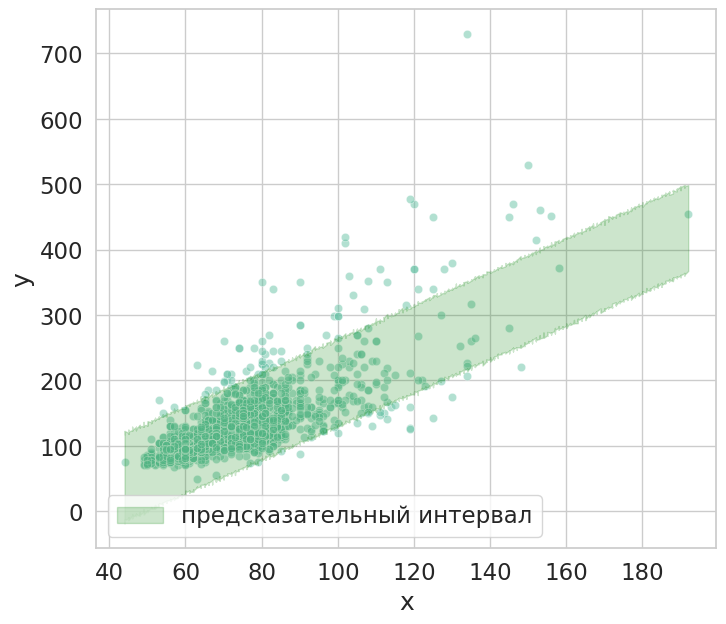

In [ ]:
import scipy.stats as sps
import seaborn as sns
y_pred = post_pred.posterior_predictive['y'].values[0]
bounds = np.percentile(y_pred, q=[2.5, 97.5], axis=0)

sns.set(font_scale=1.5, style='whitegrid', palette='Set2')
plt.figure(figsize=(8, 7))
sns.scatterplot(x=X, y=Y, alpha=0.5)
plt.fill_between(x_grid, bounds[0], bounds[1], alpha=0.2,
                 color='green', label='предсказательный интервал')
plt.xlabel("Признак")
plt.ylabel("Таргет")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

**Ну тут можно сделать дисперсию, зависящую не только от ошибки, но и от дисперсии параметров, которые мы будем считать независимыми, это позволит учесть гетероскедастичность данных, также можно сильно уменьшить априорную дисперсию признаков**

$$D[Y] = D[\theta_0] + D[\theta_1] X^2 + D[\epsilon]$$
$$D[Y] = \sigma^2 + \sigma^2 X^2 + HalfCauchy \hspace{1cm} \sigma = 0.1$$

In [ ]:
with pm.Model() as model:
    variance = 0.1
    sigma_prior = pm.HalfCauchy('sigma', beta=1, initval=1.)
    theta_0_prior = pm.Normal('theta_0', 0, sigma=np.sqrt(variance))
    theta_1_prior = pm.Normal('theta_1', 0, sigma=np.sqrt(variance))

    x = pm.MutableData('x', X, dims='dims')

    y_distr = pm.Normal(
        'y',
        mu=theta_0_prior + theta_1_prior * x,
        sigma=np.sqrt(variance + x * x * variance + sigma_prior),
        observed=Y,
        dims='dims'
    )

    trace = pm.sample(50000)

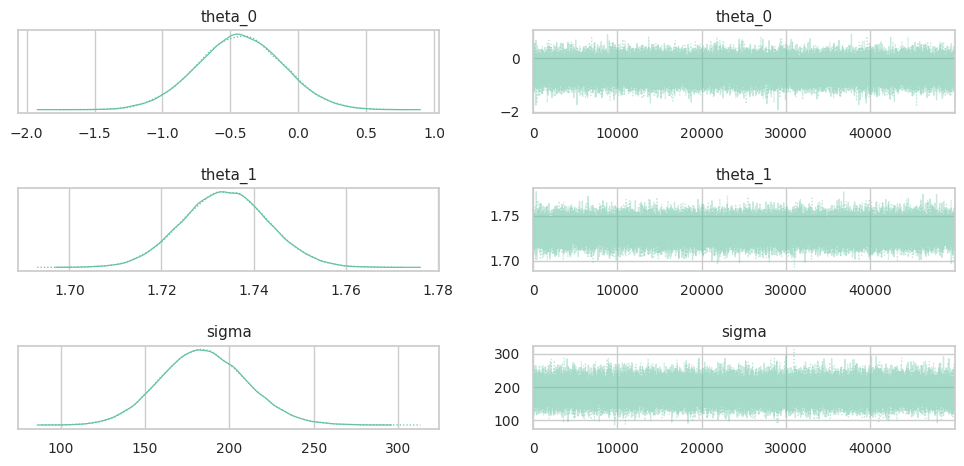

In [ ]:
pm.plot_trace(trace, figsize=(10, 5))
plt.tight_layout()

In [ ]:
import numpy as np
x_grid = np.linspace(np.min(X), np.max(X), 2000).astype(np.int32)
with model:
    pm.set_data({'x': x_grid})
    post_pred = pm.sample_posterior_predictive(trace)

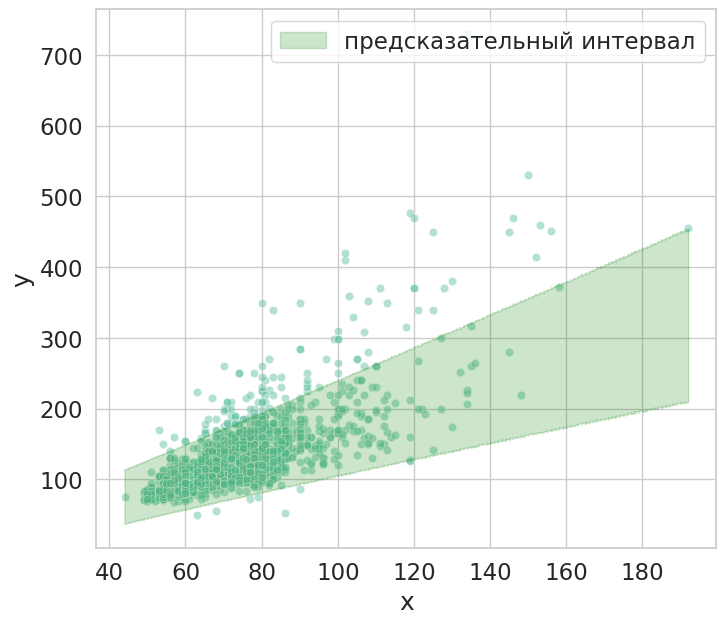

In [ ]:
import scipy.stats as sps
import seaborn as sns
y_pred = post_pred.posterior_predictive['y'].values[0]
bounds = np.percentile(y_pred, q=[2.5, 97.5], axis=0)

sns.set(font_scale=1.5, style='whitegrid', palette='Set2')
plt.figure(figsize=(8, 7))
sns.scatterplot(x=X, y=Y, alpha=0.5)
plt.fill_between(x_grid, bounds[0], bounds[1], alpha=0.2,
                 color='green', label='предсказательный интервал')
plt.xlabel("Признак")
plt.ylabel("Таргет")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

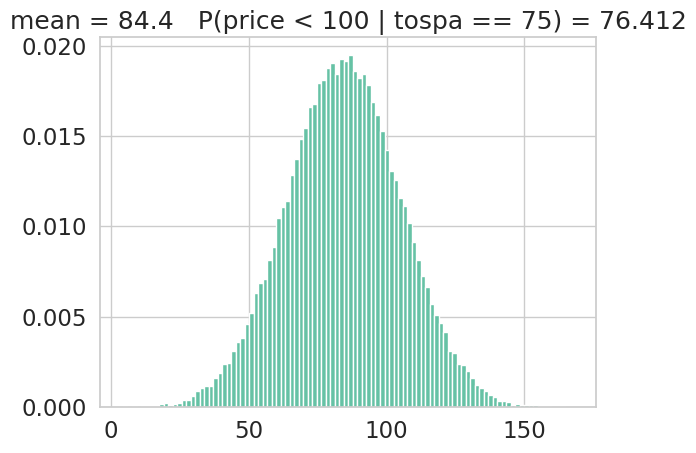

In [ ]:
plt.hist(y_pred[:, 75], bins=100, density=True)
print()
plt.title("mean = " + str(np.round(np.mean(y_pred[:, 75]), 3)) + "   P(price < 100 | tospa == 75) = " + str(np.round(np.mean(y_pred[:, 75][y_pred[:, 75] <= 100]), 3)))
plt.show()

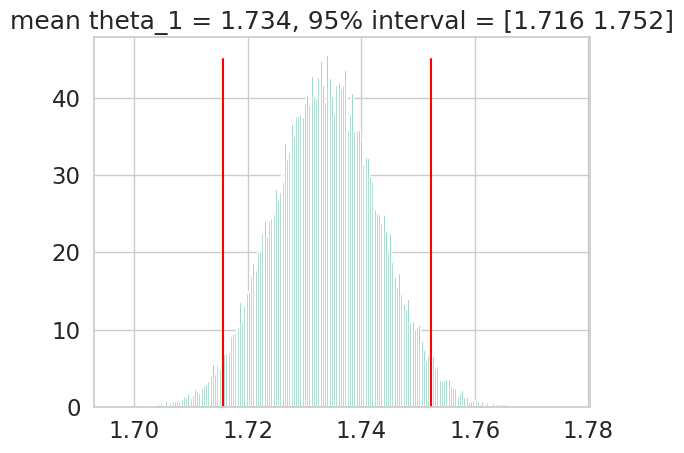

In [ ]:
theta_1_dist = np.array(trace.posterior['theta_1'])[0]
plt.hist(theta_1_dist, bins=250, density=True)
bounds = np.percentile(theta_1_dist, q=[2.5, 97.5])
plt.plot(np.tile(bounds[0], 20), np.linspace(0, 45, 20), '-r')
plt.plot(np.tile(bounds[1], 20), np.linspace(0, 45, 20), '-r')
plt.title("mean theta_1 = " + str(np.round(np.mean(theta_1_dist), 3)) + ", 95% interval = " + str(np.round(bounds, 3)))
plt.show()

Как понятно из задания, речь идет о коэффиценте наклона, то есть $\theta_1$. Изменение цены квартиры $ΔY \sim \theta_1$ c точностю до шума, то есть изменение в целом распределено как $\theta_1$, в частности матожидание изменения в точности равно матожиданию $\theta_1$ из-за нулевго матожидания шума. Отсюда вывод, что в среднем изменение будет равно 1.734, а изменение цены при изменение площади на один квадратный метр с точностью 95 процентов попадает в диапазон от 1.716 до 1.752 (из полученного апостериорного распределения)